##  Data Generation routine

In [119]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

# Set seed for reproducibility
np.random.seed(42)

# Number of samples
n = 2250

# Define US States
us_states = ["CA", "TX", "FL", "NY", "PA", "IL", "OH", "GA", "NC", "MI"]

# Define exercise frequency and diet quality categories (ordered)
exercise_categories = ["Never", "Rarely", "Occasionally", "Regularly", "Frequently"]
diet_categories = ["Very Poor", "Poor", "Average", "Good", "Excellent"]

# Initialize DataFrame
data = {
    'gender': np.random.choice(['Male', 'Female'], n),
    'age': np.random.randint(18, 81, n),
    'bmi': np.random.lognormal(mean=3.1, sigma=0.2, size=n),  # Log-normal BMI distribution
    'systolic_bp': np.random.normal(120, 20, n),
    'diastolic_bp': np.random.normal(80, 10, n),
    'exercise_frequency': np.random.choice(exercise_categories, n),
    'smoker': np.random.choice([0, 1], n),
    'family_history': np.random.choice([0, 1], n),
    'diet_quality': np.random.choice(diet_categories, n),
    'us_state': np.random.choice(us_states, n),
    'shoe_size': np.random.normal(9, 1.5, n)  # Normal distribution for shoe size
}

# Create a mildly non-linear cholesterol level
data['cholesterol_level'] = 150 + 2 * data['age'] + np.random.normal(0, 30, n)

df = pd.DataFrame(data)

def calc_risk(row):
    risk = 0
    risk += 0.03 * (row['age'] - 50)  # Linear age effect
    risk += 0.1 * np.log(row['bmi'])  # Mild non-linear BMI effect
    risk += 0.01 * (row['systolic_bp'] - 120)
    risk += 0.02 * (row['diastolic_bp'] - 80)
    risk += 0.002 * (row['cholesterol_level'] - 200)
    risk += 0.5 * row['smoker']
    risk += 0.3 * row['family_history']
    risk -= 0.1 * exercise_categories.index(row['exercise_frequency'])  # Linear effect of exercise
    risk -= 0.1 * diet_categories.index(row['diet_quality'])  # Linear effect of diet
    
    # Subtle interaction between age and BMI
    risk += 0.001 * (row['age'] - 50) * (row['bmi'] - 25)
    
    return risk

df['risk'] = df.apply(calc_risk, axis=1)

def assign_disease(risk, noise_level=0.3, base_rate=0.4):
    normalized_risk = (risk - risk.min()) / (risk.max() - risk.min())
    noisy_risk = normalized_risk + np.random.normal(0, noise_level, len(risk))
    prob_disease = base_rate + (1 - base_rate) * noisy_risk
    prob_disease = np.clip(prob_disease, 0, 1)
    return np.random.binomial(1, prob_disease)

# Control parameters
noise_level = 0.3
base_rate = 0.4

# Assign disease status
df['has_disease'] = assign_disease(df['risk'], noise_level, base_rate)

# Add mild noise to continuous variables
columns_to_noisify = ['systolic_bp', 'bmi', 'cholesterol_level', 'diastolic_bp']
for col in columns_to_noisify:
    df[col] = df[col] * np.random.uniform(0.95, 1.05, n)

# Introduce missing values
missing_fraction = 0.1
for col in ['bmi', 'systolic_bp', 'diastolic_bp', 'cholesterol_level', 'smoker', 'family_history', 'diet_quality', 'exercise_frequency']:
    df.loc[df.sample(frac=missing_fraction).index, col] = np.nan

# Introduce outliers
for col in ['bmi', 'systolic_bp', 'diastolic_bp', 'cholesterol_level']:
    num_outliers = int(n * 0.02)  # 2% outliers
    indices = np.random.choice(df.index, num_outliers, replace=False)
    mean = df[col].mean()
    std_dev = df[col].std()
    for index in indices:
        multiplier = np.random.uniform(3, 5)
        outlier = mean + std_dev * multiplier if np.random.rand() > 0.5 else mean - std_dev * multiplier
        df.at[index, col] = outlier

# Save to CSV files
df.iloc[0:2000, :].to_csv("data/updated_training_data.csv", index=False)
test_data = df.iloc[2000:, :]
test_data.to_csv("data/updated_test_data_answers.csv", index=False)
test_data.drop("has_disease", axis=1).to_csv("data/updated_test_data.csv", index=False)

In [103]:
# Set seed for reproducibility
np.random.seed(42)

# Number of samples
n = 2250

# Define US States
us_states = ["CA", "TX", "FL", "NY", "PA", "IL", "OH", "GA", "NC", "MI"]

# Define exercise frequency and diet quality categories
exercise_categories = ["Never", "Rarely", "Regularly", "Frequently"]
diet_categories = ["Poor", "Average", "Good"]

# Initialize DataFrame
data = {
    'gender': np.random.choice(['Male', 'Female'], n),
    'age': np.random.randint(18, 81, n),  # Age between 18 and 80
    'bmi': np.random.uniform(18, 35, n),  # BMI between 18 and 35
    'systolic_bp': np.random.randint(90, 181, n),  # Systolic BP between 90 and 180
    'diastolic_bp': np.random.randint(60, 121, n),  # Diastolic BP between 60 and 120
    'exercise_frequency': np.random.choice(exercise_categories, n),
    'smoker': np.random.choice([0, 1], n),
    'family_history': np.random.choice([0, 1], n),
    'diet_quality': np.random.choice(diet_categories, n),
    'us_state': np.random.choice(us_states, n),
    'shoe_size': np.random.uniform(5, 13, n)
}

# To simulate cholesterol level as weakly correlated to age:
# cholesterol_level = a*age + b + noise
# Let's assume a = 1, b = 150 to create cholesterol levels in a realistic range
# The noise will be high to keep correlation weak
a = 1
b = 150
noise_std_dev = 50  # Adjusting this value will adjust the strength of the correlation
noise = np.random.normal(0, noise_std_dev, n)
data['cholesterol_level'] = np.round(a * data['age'] + b + noise)


df = pd.DataFrame(data)

def safe_raise(value,exp):
    val = np.abs(value)**exp
    return val * np.sign(value)

# Generate target column based on risk factors, with some noise
def calc_risk(row):
    risk = 0
    if row['gender'] == 'Male':
        risk += 0.1  # Men have higher risk
    risk += 0.02 * safe_raise((row['age'] - 45),1.5) # Risk increases with age
    risk += 0.02 * safe_raise((row['bmi'] - 25),2.5)  # Risk increases with higher BMI
    risk += 0.01 * safe_raise(((row['systolic_bp'] - 120) + 0.01 * (row['diastolic_bp'] - 80)),.2)  # Risk increases with higher blood pressure
    risk += 0.02 * safe_raise((row['cholesterol_level'] - 200),.8)  # Risk increases with higher cholesterol level
    risk += row['smoker'] * 0.1  # Smoking increases risk
    risk += row['family_history'] * (0.1+ np.random.normal(0,.05))  # Family history increases risk, but this is noisy
    if row['exercise_frequency'] == 'Never':
        risk += 0.2  # Lack of exercise increases risk
    elif row['exercise_frequency'] == 'Rarely':
        risk += 0.05 
    elif row['exercise_frequency'] == 'Frequently':
        risk -= 0.1 
    if row['diet_quality'] == 'Poor':
        risk += (0.03 + np.random.normal(0,.03))  # Poor diet increases risk, but this is noisy
    elif row['diet_quality'] == 'Average':
        risk += (0.0 + np.random.normal(0,.03))  # 
    elif row['diet_quality'] == 'Good':
        risk += (-0.03 + np.random.normal(0,.03))  # Good diet decreass risk, but this is noisy

    return risk
    

df['risk'] = df.apply(calc_risk, axis=1)

df['risk'] = df.apply(calc_risk, axis=1)

# New function to assign disease status probabilistically
def assign_disease(risk, noise_level=0.5, base_rate=0.5):
    # Normalize risk to be between 0 and 1
    normalized_risk = (risk - risk.min()) / (risk.max() - risk.min())
    
    # Add noise to the normalized risk
    noisy_risk = normalized_risk + np.random.normal(0, noise_level, len(risk))
    
    # Calculate probability of disease
    prob_disease = base_rate + (1 - base_rate) * noisy_risk
    
    # Clip probabilities to be between 0 and 1
    prob_disease = np.clip(prob_disease, 0, 1)
    
    # Assign disease status based on probability
    return np.random.binomial(1, prob_disease)

# Control parameters
noise_level = 0.9  # Adjust this to control noise (higher value = more noise)
base_rate = 0.5    # Adjust this to control the base rate of the disease

# Assign disease status
df['has_disease'] = assign_disease(df['risk'], noise_level, base_rate)

# Add noise to continuous variables
columns_to_noisify = ['systolic_bp', 'bmi', 'cholesterol_level', 'diastolic_bp']
for col in columns_to_noisify:
    df[col] = df[col] * np.random.uniform(0.8, 1.2, n)

# Introduce missing values
missing_fraction = 0.1
for col in ['bmi', 'systolic_bp', 'diastolic_bp', 'cholesterol_level', 'smoker', 'family_history', 'diet_quality', 'exercise_frequency']:
    df.loc[df.sample(frac=missing_fraction).index, col] = np.nan

# Introduce outliers
for col in ['bmi', 'systolic_bp', 'diastolic_bp', 'cholesterol_level']:
    num_outliers = int(n * np.random.uniform(1, 10) / 1000)
    indices = np.random.choice(df.index, num_outliers, replace=False)
    mean = df[col].mean()
    std_dev = df[col].std()
    for index in indices:
        multiplier = np.random.uniform(5, 10)
        outlier = mean + std_dev * multiplier if np.random.rand() > 0.5 else mean - std_dev * multiplier
        df.at[index, col] = outlier

df = df.drop("risk",axis=1)

# Save to CSV files
df.iloc[0:2000, :].to_csv("data/updated_training_data.csv", index=False)
test_data = df.iloc[2000:, :]
test_data.to_csv("data/updated_test_data_answers.csv", index=False)
test_data.drop("has_disease", axis=1).to_csv("data/updated_test_data.csv", index=False)

## Sample Answer

In [2]:
import pandas as pd

data = pd.read_csv("./data/training_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              2000 non-null   object 
 1   age                 2000 non-null   int64  
 2   bmi                 1805 non-null   float64
 3   systolic_bp         1803 non-null   float64
 4   diastolic_bp        1804 non-null   float64
 5   exercise_frequency  1805 non-null   object 
 6   smoker              1800 non-null   float64
 7   family_history      1797 non-null   float64
 8   diet_quality        1797 non-null   object 
 9   us_state            2000 non-null   object 
 10  shoe_size           2000 non-null   float64
 11  cholesterol_level   1798 non-null   float64
 12  risk                2000 non-null   float64
 13  has_disease         2000 non-null   int64  
dtypes: float64(8), int64(2), object(4)
memory usage: 218.9+ KB


<Axes: ylabel='Frequency'>

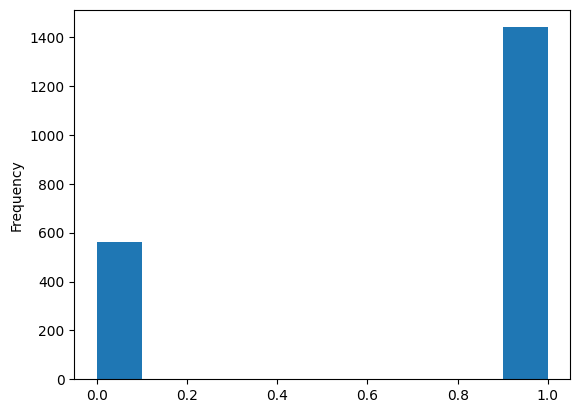

In [3]:
data['has_disease'].plot.hist()

Slightly imbalanced - if we wanted to do something about this we might try oversampling.

Now checking for outliers...

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>], dtype=object)

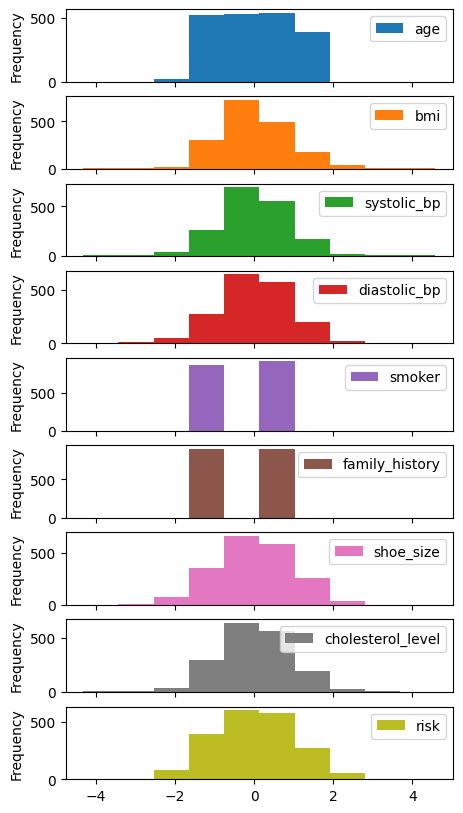

In [7]:
import numpy as np
data_features = data.drop("has_disease",axis=1)
numeric = [col for col in data_features.columns if data_features[col].dtype in ["float64","int64"]]
data_features[numeric].apply(lambda x: (x-np.mean(x))/np.std(x)).plot.hist(subplots=True, figsize=(5,10))


Everything looks ok.  Not going to worry about it.

In [10]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer


data_features = data.drop("has_disease",axis=1)
data_target = data["has_disease"]

categorical = [col for col in data_features.columns if data_features[col].dtype == "object"]
for c in categorical:
    elts = [str(e) for e in data_features[c].unique()]
   

numeric = [col for col in data_features.columns if data_features[col].dtype in ["float64","int64"]]


binary_cols = ['smoker','family_history']
non_binary_cols = [x for x in numeric if x not in binary_cols]
oe_cols = ["gender","exercise_frequency","diet_quality"]
oe = OrdinalEncoder(categories=[["Female","Male"],["Never","Rarely","Regularly","Frequently"],["Poor","Average","Good"]])

oh_cols = ["us_state"]

# Using most frequent here, even though I'd prefer something smarter
oe_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),oe)

# just states
oh_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore",drop="first"))

# use most frequent here
binary_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"))

# Just median for all the rest, and scale
num_pipeline = make_pipeline(SimpleImputer(strategy="median"),StandardScaler())

preprocessing = ColumnTransformer([
    ("OH_OE",oh_pipeline,oe_cols),
    ("OH_OH",oh_pipeline,oh_cols),
    ("BIN",binary_pipeline,binary_cols),
    ("NUM",num_pipeline,non_binary_cols)])

preprocessing.fit_transform(data)
preprocessing.get_feature_names_out()

# Not rebalancing classes here
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
pipeline = make_pipeline(preprocessing,LogisticRegression())

cross_validate(pipeline,data_features,data_target,scoring=['f1','precision','recall'])


{'fit_time': array([0.02831101, 0.02423   , 0.02378798, 0.02486706, 0.02135706]),
 'score_time': array([0.01452017, 0.0138061 , 0.01349688, 0.01402068, 0.01219797]),
 'test_f1': array([0.82634731, 0.83783784, 0.826546  , 0.84444444, 0.8313253 ]),
 'test_precision': array([0.72631579, 0.73809524, 0.73066667, 0.73643411, 0.73404255]),
 'test_recall': array([0.95833333, 0.96875   , 0.95138889, 0.98958333, 0.95833333])}